In [43]:
import warnings
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from pandas.core.common import flatten
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from xgboost import XGBClassifier
from collections import Counter
from collections import defaultdict

In [39]:
warnings.filterwarnings("ignore")

In [14]:
fx = pd.read_csv("https://raw.githubusercontent.com/penguinwang96825/Forex-Prediction/master/forex/Currency_Data_EURUSD.csv", 
                 index_col=False, 
                 delimiter=',')
fx.columns = ["currecny", "date", "Open", "High", "Low", "Close"]
fx["date"] = pd.to_datetime(fx["date"])
fx.sort_values(by='date', inplace=True)
fx.reset_index(drop=True, inplace=True)
fx["label"] = fx["Close"].diff(periods=1)
fx.dropna(inplace=True)
fx.drop("currecny", axis=1, inplace=True)
fx["label"] = fx["label"].map(lambda x: 1 if float(x)>=0 else 0)
fx.head()

,date,Open,High,Low,Close,label
1,2007-01-10,1.4232,1.4238,1.4140,1.4155,1
2,2007-01-11,1.4488,1.4488,1.4405,1.4425,1
3,2007-02-08,1.3669,1.3705,1.3652,1.3704,0
4,2007-02-11,1.4425,1.4528,1.4416,1.4504,1
5,2007-03-08,1.3703,1.3819,1.3684,1.3774,0


In [15]:
news = pd.read_csv("https://raw.githubusercontent.com/penguinwang96825/Forex-Prediction/master/news/indian_news_large.csv", 
                   delimiter=',')
news["date"] = pd.to_datetime(news["news_date"])
news = news[news["news_category"] == "business"]
news = news[["date", "news_headline", "news_article"]]
news = news.groupby(['date'],as_index=False).agg({'news_headline': 'sum', "news_article": "sum"})
news.sort_values(by='date')
news.head()

,date,news_headline,news_article
0,2013-06-25,IIM-Kozhikode: 54.29% women in new batchGoogle...,"IIM, Kozhikode's will have a record 54.29% of ..."
1,2013-06-26,Telecom operators slashing data charges'Amul' ...,Smartphone owners in India are in for a treat ...
2,2013-06-27,Samsung shares hit a 9-month low,Samsung Electronics shares slumped 3% to a nin...
3,2013-06-28,Cabinet approves doubling of Gas pricesGoogle ...,"Despite opposition, the Cabinet Committee on E..."
4,2013-06-29,BlackBerry's share price dropped by 25%Petrol ...,BlackBerry's share price dropped by 25% in pre...


In [16]:
news_and_fx = pd.merge(news, fx, on=["date"])
news_and_fx.set_index('date', inplace=True)
news_and_fx["headline_len"] = news_and_fx["news_headline"].map(len)
news_and_fx["article_len"] = news_and_fx["news_article"].map(len)
print(Counter(news_and_fx["label"]))
news_and_fx.head()

Counter({0: 816, 1: 784})


,news_headline,news_article,Open,High,Low,Close,label,headline_len,article_len
date,,,,,,,,,
2013-06-25,IIM-Kozhikode: 54.29% women in new batchGoogle...,"IIM, Kozhikode's will have a record 54.29% of ...",1.3120,1.3151,1.3065,1.3077,0,158,1501
2013-06-26,Telecom operators slashing data charges'Amul' ...,Smartphone owners in India are in for a treat ...,1.3077,1.3087,1.2985,1.3012,0,139,1274
2013-06-27,Samsung shares hit a 9-month low,Samsung Electronics shares slumped 3% to a nin...,1.3012,1.3057,1.3000,1.3038,1,32,247
2013-06-28,Cabinet approves doubling of Gas pricesGoogle ...,"Despite opposition, the Cabinet Committee on E...",1.3038,1.3103,1.2991,1.3010,0,199,1962
2013-07-01,Rupee worst among Asian currency in Q1Many B-s...,The rupee lost as much as 8.6% in the April-Ju...,1.3075,1.3120,1.3017,1.3117,1,106,1030


In [17]:
train = news_and_fx.loc[:"2019-03-07"]
test = news_and_fx.loc["2019-03-08":]

In [5]:
def clean_text(text):
    tokens_list = word_tokenize(text)
    tokens_list = [word for word in tokens_list if word.isalpha()]
    tokens_list = [w for w in tokens_list if not w in stopwords.words('english')]
    return tokens_list

In [18]:
# Reference from https://www.kaggle.com/mohanamurali/bgow-tf-idf-lr-w2v-lgb-bayesopt
class TfidfWord2VecVectorizer:
    def __init__(self):
        # Load in pretrained word vectors from https://github.com/Kyubyong/wordvectors
        print("Loading in word vectors...")
        self.w2v = KeyedVectors.load_word2vec_format(
            r"D:\embedding\GoogleNews-vectors-negative300.bin", binary=True)
        self.word2vec = {w: vec for w, vec in zip(self.w2v.index2word, self.w2v.vectors)}
        self.word2weight = None
        self.dim = self.w2v.vector_size
        print("Finished loading in word vectors.")
        
    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [19]:
# ! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz" --no-check-certificate
class Word2VecVectorizer:
    def __init__(self):
        # Load in pretrained word vectors from https://github.com/Kyubyong/wordvectors
        print("Loading in word vectors...")
        self.w2v = KeyedVectors.load_word2vec_format(
            r"D:\embedding\GoogleNews-vectors-negative300.bin", binary=True)
        self.word2vec = {w: vec for w, vec in zip(self.w2v.index2word, self.w2v.vectors)}
        print("Finished loading in word vectors.")
        
    def fit(self, data):
        pass
    
    def transform(self, data):
        # Dimension of feature
        self.D = self.w2v.wv.vector_size
        
        # Convert sentences using bag of word
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            # First, remove stopwords and emoji. Second, tokenise sentence using mecab.
            tokens = clean_text(sentence)
            vecs = []
            m = 0
            for word in tokens:
                try: 
                    vec = self.w2v.wv.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [20]:
def performance(model, x_train, y_train, x_test, y_test):
    print("test accuracy: ", round(model.score(x_test, y_test), 4))
    print("f-beta score: ", round(f1_score(y_test, model.predict(x_test)), 4))
    print("roc auc score: ", round(roc_auc_score(y_test, model.predict(x_test)), 4))
    print("matthews corrcoef: ", round(matthews_corrcoef(y_test, model.predict(x_test)), 4))
    print("confusion matrix: \n", confusion_matrix(y_test, model.predict(x_test)))

In [22]:
# If using TfidfWord2VecVectorizer(), then set it to True. Instead, set it to False.
weighted = True
# If using news headline as training data, then set it to True. Instead, set it to False.
using_headline = True

if weighted:
    if using_headline:
        print("Using TfidfWord2VecVectorizer.\n")
        vectorizer = TfidfWord2VecVectorizer()
        x_train = vectorizer.fit_transform(train.news_headline)
        y_train = train.label
        x_test = vectorizer.transform(test.news_headline)
        y_test = test.label
        print("\n# of train data: {}\n# of features: {}\n".format(x_train.shape[0], x_train.shape[1]))
        print("\n# of test data: {}\n# of features: {}\n".format(x_test.shape[0], x_test.shape[1]))
        print("Training data: \n", x_train)
    else:
        print("Using TfidfWord2VecVectorizer.\n")
        vectorizer = TfidfWord2VecVectorizer()
        x_train = vectorizer.fit_transform(train.news_article)
        y_train = train.label
        x_test = vectorizer.transform(test.news_article)
        y_test = test.label
        print("\n# of train data: {}\n# of features: {}\n".format(x_train.shape[0], x_train.shape[1]))
        print("\n# of test data: {}\n# of features: {}\n".format(x_test.shape[0], x_test.shape[1]))
        print("Training data: \n", x_train)
else: 
    if using_headline:
        print("Using Word2VecVectorizer.\n")
        vectorizer = Word2VecVectorizer()
        x_train = vectorizer.fit_transform(train.news_headline)
        y_train = train.label
        x_test = vectorizer.fit_transform(test.news_headline)
        y_test = test.label
        print("\n# of train data: {}\n# of features: {}\n".format(x_train.shape[0], x_train.shape[1]))
        print("\n# of test data: {}\n# of features: {}\n".format(x_test.shape[0], x_test.shape[1]))
        print("Training data: \n", x_train)
    else: 
        print("Using Word2VecVectorizer.\n")
        vectorizer = Word2VecVectorizer()
        x_train = vectorizer.fit_transform(train.news_article)
        y_train = train.label
        x_test = vectorizer.fit_transform(test.news_article)
        y_test = test.label
        print("\n# of train data: {}\n# of features: {}\n".format(x_train.shape[0], x_train.shape[1]))
        print("\n# of test data: {}\n# of features: {}\n".format(x_test.shape[0], x_test.shape[1]))
        print("Training data: \n", x_train)

Using TfidfWord2VecVectorizer.

Loading in word vectors...
Finished loading in word vectors.

# of train data: 1375
# of features: 300


# of test data: 225
# of features: 300

Training data: 
 [[-0.12700029  0.08604938  0.01470021 ... -0.00903478 -0.12132929
   0.12989105]
 [-0.15275337  0.11323019 -0.01586745 ... -0.02172263 -0.09243777
   0.17869088]
 [-0.1933339   0.12984982 -0.02588227 ... -0.02387366 -0.10598814
   0.13183005]
 ...
 [-0.16754821  0.10493602  0.01396004 ... -0.00875499 -0.10141815
   0.15162148]
 [-0.1559691   0.09705696  0.0231237  ... -0.01185597 -0.10406656
   0.15383247]
 [-0.16409096  0.10386652  0.00372783 ... -0.01746836 -0.0917742
   0.16335692]]


In [23]:
xgb = XGBClassifier(
    learning_rate=0.01,  
    n_estimators=400, 
    random_state=17, 
    slient = 0)

params = { 
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15, 20]
}

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=17)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=6, 
    cv=skf.split(x_train, y_train), 
    verbose=2, 
    random_state=17)
random_search.fit(x_train, y_train)
xgb = random_search.best_estimator_
performance(xgb, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:  1.1min remaining:   16.1s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:  1.1min finished


test accuracy:  0.4978
f-beta score:  0.4645
roc auc score:  0.4961
matthews corrcoef:  -0.0079
confusion matrix: 
 [[63 59]
 [54 49]]


In [29]:
news_and_fx.to_csv(r"C:\Users\YangWang\Desktop\test\news_and_forex.csv", index=False)

In [40]:
pred = xgb.predict(x_test)
pred = pred.tolist()
pred = [1 if p == 1 else -1 for p in pred]

In [41]:
test

,news_headline,news_article,Open,High,Low,Close,label,headline_len,article_len,pred
date,,,,,,,,,,
2019-03-09,PM Modi hai toh mumkin hai: Congress on Nirav ...,After 'The Telegraph' released a video on Satu...,1.0974,1.0979,1.0926,1.0970,0,1143,6568,1
2019-03-10,State govt approves setting up two IT parks in...,The Goa government has approved setting up two...,1.0958,1.0999,1.0941,1.0983,1,925,5524,-1
2019-03-12,Godrej Properties presents homes with 5-tier s...,"With child-safe homes, RFID enabled complex, 2...",1.1075,1.1094,1.1066,1.1088,1,1568,9541,-1
2019-03-13,Wipro's Azim Premji raises contribution to cha...,Wipro Chairman Azim Premji has earmarked all e...,1.1290,1.1315,1.1277,1.1303,1,1459,8630,1
2019-03-14,Will burn Chinese goods on Mar 19 to teach a l...,Traders' body CAIT and RSS' economic wing Swad...,1.1303,1.1339,1.1294,1.1299,0,1207,7295,-1
...,...,...,...,...,...,...,...,...,...,...
2020-02-28,"Investors lose ₹11 lakh cr in 6 sessions, Sens...",Sensex registered its worst week since 2009 sl...,1.0980,1.1053,1.0951,1.1026,1,917,4625,-1
2020-03-01,"Apple sends iPads, face masks to employees str...",Apple has sent 'care packages' to its employee...,1.1170,1.1180,1.1125,1.1161,1,452,2513,-1
2020-03-02,Sensex ends 153 points lower as govt confirms ...,Sensex gave up all gains and closed 153 points...,1.1084,1.1096,1.1036,1.1059,0,465,2440,-1


In [44]:
from abc import ABCMeta, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

class Strategy(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        raise NotImplementedError("Should implement generate_signals()!")
        
class Portfolio(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        raise NotImplementedError("Should implement backtest_portfolio()!")

        
class RandomForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = np.sign(np.random.randn(len(signals)))
        return signals
    
class MarketIntradayPortfolio(Portfolio):
    
    def __init__(self, symbol, bars, signals, initial_capital=100000.0, trading_sum=100):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trading_sum = float(trading_sum)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol] = self.trading_sum*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
        
        
        portfolio['price_diff'] = self.bars['Close']-self.bars['Open']
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']

        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

In [45]:
class MachineLearningForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = pred
        return signals

In [46]:
test['Close'] = test['Close'].shift(-1)

rfs = MachineLearningForecastingStrategy('EURUSD', test, pred)
signals = rfs.generate_signals()
portfolio = MarketIntradayPortfolio('EURUSD', test, signals, initial_capital=100000.0, trading_sum=10000)
returns = portfolio.backtest_portfolio()

In [48]:
returns['signal'] = signals
our_pct_growth = returns['total'].pct_change().cumsum()
benchmark_ptc_growth = test['Close'].pct_change().cumsum()

In [60]:
returns

,price_diff,profit,total,returns,signal
date,,,,,
2019-03-09,0.0009,9.0,100009.0,NaN,1
2019-03-10,0.0130,-130.0,99879.0,-0.001300,-1
2019-03-12,0.0228,-228.0,99651.0,-0.002283,-1
2019-03-13,0.0009,9.0,99660.0,0.000090,1
2019-03-14,0.0023,-23.0,99637.0,-0.000231,-1
...,...,...,...,...,...
2020-02-28,0.0181,-181.0,98890.0,-0.001827,-1
2020-03-01,-0.0111,111.0,99001.0,0.001122,-1
2020-03-02,0.0075,-75.0,98926.0,-0.000758,-1


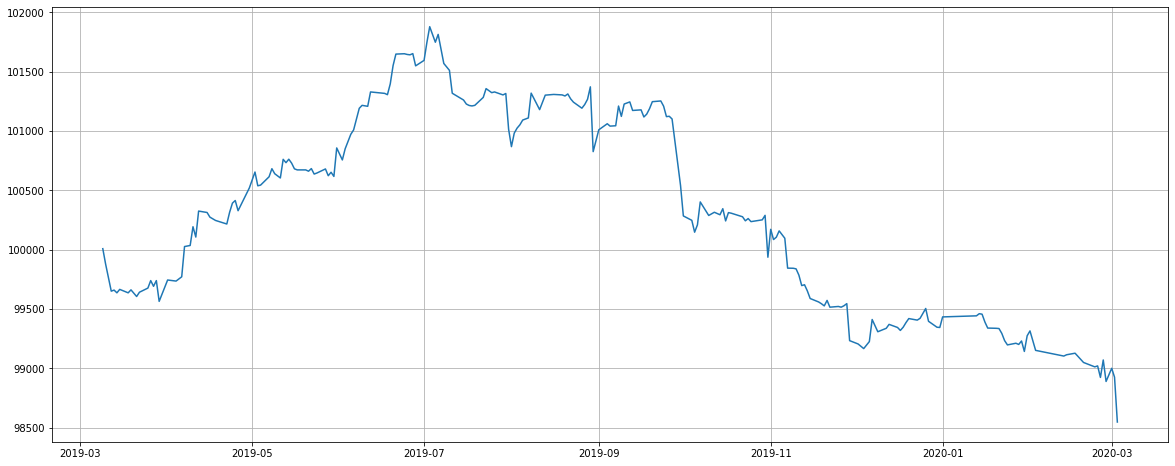

In [57]:
plt.figure(figsize=(20, 8))
plt.plot(returns['total'])
plt.grid()
plt.show()

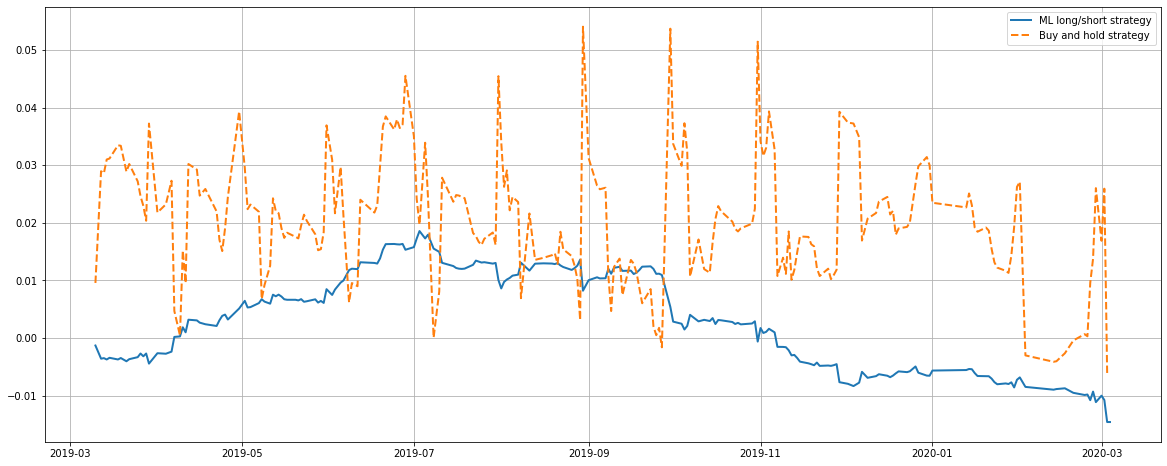

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
plt.legend()
plt.grid()
plt.show()

In [50]:
def sharpe(returns):
    return np.sqrt(len(returns)) * returns.mean() / returns.std()

In [52]:
print(sharpe(our_pct_growth))
print(sharpe(benchmark_ptc_growth))

5.853935470147723
27.906190492123585
